In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")

import os
import sys; sys.path.append('../')
import numpy as np
from numpy.random import default_rng

import scipy.io as sio
import pysindy as ps
from PDE_FIND import build_linear_system, print_pde, TrainSTRidge, measure_pce
from best_subset import *
from frols import frols
from UBIC import *
from solvel0 import solvel0
from findiff import FinDiff
import sgolay2

Sklearn's version: 1.2.2


#### Load data

In [2]:
n = 128
data = sio.loadmat(f"../../PDE-FIND/Datasets/reaction_diffusion_3d_{n}.mat")
# data = sio.loadmat(f"../Datasets/reaction_diffusion_3d_{n}.mat")

u_sol = (data['usol']).real
v_sol = (data['vsol']).real
x = (data['x'][0]).real
y = (data['y'][0]).real
z = (data['z'][0]).real
t = (data['t'][0]).real

del data

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

# Ground truth
ground_indices_u = (0, 1, 5, 9, 15, 23)
ground_coeff_u = np.array([0.014, -0.014, -1.000, 0.020, 0.020, 0.020])
ground_indices_v = (2, 5, 10, 16, 24)
ground_coeff_v = np.array([-0.067, 1.0, 0.01, 0.01, 0.01])

In [3]:
time = t
u = np.zeros((n, n, n, len(time), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
X, Y, Z, T = np.meshgrid(x, y, z, time, indexing="ij")
spatiotemporal_grid = np.asarray([X, Y, Z, T])
spatiotemporal_grid = np.transpose(spatiotemporal_grid, axes=[1, 2, 3, 4, 0])
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    is_uniform=True,
    include_interaction=False,
    include_bias=True,
    periodic=True,
    K=10000,
    cache=True
)

#### Add noise

In [4]:
np.random.seed(100)
noise_lv = 0.1
domain_noise = 0.01*np.abs(noise_lv)*np.std(u)*np.random.randn(*u.shape)
u = u + domain_noise

#### Denoise

In [5]:
denoise = True
if denoise: 
    un = u[:, :, :, :, 0]
    vn = u[:, :, :, :, 1]

    div = 30
    ws = max(un.shape[:-2])//div; po = 5
    if ws%2 == 0: ws -=1

    nun = np.zeros_like(un)
    for i in trange(un.shape[-1]):
        for j in range(un.shape[-2]):
            nun[:, :, j, i] = sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(un[:, :, j, i])
    un = nun.copy()
    del nun
    
    nvn = np.zeros_like(vn)
    for i in trange(vn.shape[-1]):
        for j in range(vn.shape[-2]):
            nvn[:, :, j, i] = sgolay2.SGolayFilter2(window_size=ws, poly_order=po)(vn[:, :, j, i])
    vn = nvn.copy()
    del nvn
    
    dim = 10

    un = un.reshape(-1, len(t))
    uun, sigmaun, vun = np.linalg.svd(un, full_matrices=False); vun = vun.T
    un = uun[:,0: dim].dot(np.diag(sigmaun[0:dim]).dot(vun[:,0:dim].T))
    un = un.reshape(len(x), len(y), len(z), len(t))

    vn = vn.reshape(-1, len(t))
    uvn, sigmavn, vvn = np.linalg.svd(vn, full_matrices=False); vvn = vvn.T
    vn = uvn[:,0: dim].dot(np.diag(sigmavn[0:dim]).dot(vvn[:,0:dim].T))
    vn = vn.reshape(len(x), len(y), len(z), len(t))

    u = np.stack([un, vn], axis=-1)
    del un, vn

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.55it/s]


#### Applying best-subset regression on the weak formulation

In [6]:
# optimizer = ps.SR3(threshold=1e-5, normalize_columns=True, max_iter=100)
# model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, cache=True)
# model.fit(u, ensemble=False, library_ensemble=True)
# model.print()
# X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot

In [7]:
### To reproduce the exact %CE reported in the paper ###
X_pre = np.load("./denoised_files/GS_X_pre_noise1e-1_denoised.npy")
y_pre = np.load("./denoised_files/GS_y_pre_noise1e-1_denoised.npy")

In [8]:
max_complexity = 12

target_index = 0
frols_coeffs,selected_inds_list,_,_,_ = frols(y_pre[:, target_index:target_index+1], X_pre, 
                                              max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
ever = reduce(np.union1d, selected_inds_list)
_, bs = brute_force_all_subsets(X_pre[:, ever], 
                                y_pre[:, target_index:target_index+1], 
                                max_support_size=max_complexity)
best_subsets_u = [tuple(ever[list(b)]) for b in bs]
del bs

target_index = 1
frols_coeffs,selected_inds_list,_,_,_ = frols(y_pre[:, target_index:target_index+1], X_pre, 
                                              max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
ever = reduce(np.union1d, selected_inds_list)
_, bs = brute_force_all_subsets(X_pre[:, ever], 
                                y_pre[:, target_index:target_index+1], 
                                max_support_size=max_complexity)
best_subsets_v = [tuple(ever[list(b)]) for b in bs]
del bs

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.85it/s]


In [9]:
u_pre, v_pre = y_pre[:, 0:1], y_pre[:, 1:2]
del y_pre

#### Model selection by the UBIC (Algorithm 1)

In [10]:
tau = 3; per = 75 # 85
scale = np.log(len(u_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_u, (X_pre, u_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_u])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_u):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], u_pre)/np.log(len(u_pre))-com # old version without scale
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], u_pre))-np.log(len(u_pre))*com
    lower_bounds.append(lower_bound)
    
last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(u_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    # better use imp = abs(diff_bic/(b_bics[min(last_bc, now_bc)]*diff_com))
    # if generally now_bc < last_bc
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_u = last_lam
last_ubic_d_u = last_ubic
last_bc_d_u = last_bc
uns_u = b_uns
last_lam, last_ubic, last_bc

0.13696923174845235
5 <---> 5 inf
5 <---> 5 inf
5 <---> 5 inf


(0.0,
 array([-199409.01571746, -206249.85744539, -219768.49973045,
        -250412.62102061, -271318.6918666 , -313925.64324027,
        -313922.93529288, -313915.76704176, -313908.28846223,
        -313900.68000578, -313893.37111871, -313878.47810631]),
 5)

In [11]:
tau = 3; per = 75 # 85
scale = np.log(len(v_pre))
# scale = 1

post_means, b_bics, b_uns = baye_uncertainties(best_subsets_v, (X_pre, v_pre), u_type='cv1', take_sqrt=True)
predictions = X_pre@post_means

b_bics = np.array(b_bics)
complexities = np.array([len(bs) for bs in best_subsets_v])
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
# thres = 0.02
print(thres)

lower_bounds = []
for k, efi in enumerate(best_subsets_v):
    com = len(efi)
    assert com == np.count_nonzero(post_means[:, k:k+1])
    # lower_bound = 2*log_like_value(predictions[:, k:k+1], v_pre)/np.log(len(v_pre))-com # old version without scale
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], v_pre))-np.log(len(v_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(v_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    # better use imp = abs(diff_bic/(b_bics[min(last_bc, now_bc)]*diff_com))
    # if generally now_bc < last_bc
    imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), np.nan_to_num(imp, nan=np.inf))

    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    
best_bc = last_bc
if abs((b_bics[last_bc]-b_bics[last_bc-1])/b_bics[last_bc-1]) < thres:
    best_bc = best_bc - 1

last_lam = round(last_lam, 10)
last_lam_d_v = last_lam
last_ubic_d_v = last_ubic
last_bc_d_v = last_bc
uns_v = b_uns
last_lam, last_ubic, last_bc

0.10598674457151297
4 <---> 4 inf
4 <---> 4 inf
4 <---> 7 1.465320735032407e-05


(1.51625528,
 array([-157262.09616402, -130309.21118815, -188006.82684939,
        -245195.50010284, -325565.48189545, -325564.20781034,
        -325558.74969488, -325553.04892461, -325504.96014557,
        -325460.46445174, -325441.57916254, -325238.58852882]),
 4)

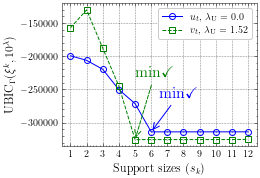

In [12]:
assert list(map(len, best_subsets_u)) == list(map(len, best_subsets_v))
complexities = list(map(len, best_subsets_u))
with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots()
    ax.plot(complexities, last_ubic_d_u, 'o-', c='blue', markerfacecolor='none', label="$u_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_u, 2)))
    ax.plot(complexities, last_ubic_d_v, 's--', c='green', markerfacecolor='none', label="$v_t,\, \lambda_{\\textrm{U}}=$ "+str(round(last_lam_d_v, 2)))
    ax.set_xticks(complexities)
    ax.set_ylabel("$\\textrm{UBIC}_{\\Gamma}(\\xi^{k}, 10^{\\lambda})$", fontsize=12)
    ax.set_xlabel("Support sizes ($s_{k}$)", fontsize=12)

    plt.annotate('min$\checkmark$', fontsize=16, c='blue', 
             xy=(complexities[last_bc_d_u], last_ubic_d_u[last_bc_d_u]), 
             xytext=(complexities[last_bc_d_u]+0.5, last_ubic_d_u[last_bc_d_u]+0.5e5), 
             arrowprops={'arrowstyle': '->', 'linestyle':'-', 'color':'blue'})
    
    plt.annotate('min$\checkmark$', fontsize=16, c='green', 
             xy=(complexities[last_bc_d_v], last_ubic_d_v[last_bc_d_v]), 
             xytext=(complexities[last_bc_d_v], last_ubic_d_v[last_bc_d_v]+0.925e5), 
             arrowprops={'arrowstyle': '->', 'linestyle':'--', 'color':'green'})
    
    plt.legend()
    plt.show()

#### Percent coefficient error

In [13]:
assert np.alltrue(best_subsets_v[last_bc_d_v] == ground_indices_v) and np.alltrue(best_subsets_u[last_bc_d_u] == ground_indices_u)
errs_u = measure_pce(np.linalg.lstsq(X_pre[:, ground_indices_u], u_pre, rcond=None)[0].flatten(), 
                     ground_coeff_u)
errs_v = measure_pce(np.linalg.lstsq(X_pre[:, ground_indices_v], v_pre, rcond=None)[0].flatten(), 
                     ground_coeff_v)
print(errs_u.mean(), errs_u.std())
print(errs_v.mean(), errs_v.std())

0.055415449636699976 0.08751867999585022
0.010965596710386558 0.010720272536196155
